# Load modules
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?)  

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 222 GB / percent used: 11.9 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'snc'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'
    
var_label = 'Snow cover extent [%]'
var_label_trends = 'Snow cover extent trends [%/dec]'
var_label_bias = 'Snow cover bias [%]'
cmap='viridis'
levels=plot.arange(0,100,10)

[#Load-ensemble-mean](#Load-ensemble-mean)

## Load first member

In [3]:
realization = 'r1i1p1f1'

# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load amip
da_amip = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/amip/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load HighResMIP
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

## Create ensemble mean

### da_historical

In [11]:
realization = '*'
experiment = 'historical'

da_historical_ens = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='nested', concat_dim='realization', parallel=True
).sel(time=period)[var]

da_historical_ens

<xarray.DataArray 'snc' (realization: 32, time: 408, lat: 143, lon: 144)>
dask.array<getitem, shape=(32, 408, 143, 144), dtype=float32, chunksize=(1, 408, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: realization
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [12]:
ens = da_historical_ens.mean('realization', keep_attrs=True)
ens.attrs['realization'] = da_historical_ens.realization.size
ens

<xarray.DataArray 'snc' (time: 408, lat: 143, lon: 144)>
dask.array<mean_agg-aggregate, shape=(408, 143, 144), dtype=float32, chunksize=(408, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella
    realization:         32

In [16]:
root_path='/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/ens/'+table+'/'+var+'/gr/latest'
root_path
# mkdir -p root_path

'/data/mlalande/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/ens/LImon/snc/gr/latest'

In [17]:
ens.to_netcdf(root_path+'/'+var+'_'+table+'_'+model+'_'+experiment+'_ens_gr_198101-201412.nc')

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### da_amip

In [21]:
realization = '*'
experiment = 'amip'

da_amip = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/*-201412.nc', 
    combine='nested', concat_dim='realization', parallel=True
).sel(time=period)[var]
da_amip

<xarray.DataArray 'snc' (realization: 21, time: 408, lat: 143, lon: 144)>
dask.array<getitem, shape=(21, 408, 143, 144), dtype=float32, chunksize=(1, 408, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: realization
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [22]:
ens = da_amip.mean('realization', keep_attrs=True)
ens.attrs['realization'] = da_amip.realization.size
ens

<xarray.DataArray 'snc' (time: 408, lat: 143, lon: 144)>
dask.array<mean_agg-aggregate, shape=(408, 143, 144), dtype=float32, chunksize=(408, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella
    realization:         21

In [23]:
root_path='/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/ens/'+table+'/'+var+'/gr/latest'
root_path
# mkdir -p root_path

'/data/mlalande/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/amip/ens/LImon/snc/gr/latest'

In [24]:
ens.to_netcdf(root_path+'/'+var+'_'+table+'_'+model+'_'+experiment+'_ens_gr_198101-201412.nc')

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# Load ensemble mean
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?) 

In [3]:
realization = 'ens'
# Load historical ens
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
)
# Load amip ens
experiment='amip'
da_amip = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
)

# No ensembles for land-hist and HR
realization = 'r1i1p1f1'
# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
# Load HighResMIP
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load obs

## NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

In [4]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

In [5]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
ds_rutger

<xarray.Dataset>
Dimensions:               (cols: 88, rows: 88, time: 1774)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-05 ... 2014-12-29
    snow_cover_threshold  float32 ...
    latitude              (rows, cols) float64 ...
    longitude             (rows, cols) float64 ...
Dimensions without coordinates: cols, rows
Data variables:
    coord_system          |S1 ...
    land                  (rows, cols) float32 ...
    area                  (rows, cols) float32 ...
    snow_cover_extent     (time, rows, cols) float32 ...
Attributes:
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        nhsce_v01r01_19661004_20191202.nc
    naming_authority:          gov.noaa.ncdc
    metadata_link:             https://doi.org/10.7289/V5N014G9
    title:                     Climate Data Record (CDR) of Northern Hemisphe...
    product_version:           v01r01
    summary:                   The data record for the NH SCE CDR spans from ...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW C...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Ear...
    platform:                  ESSA, NOAA POES, SMS, DMSP, GOES, TIROS, METEO...
    sensor:                    VIDEO CAMERA, VISSR, VAS, VHRR, AVHRR, VISSR-G...
    cdm_data_type:             Grid
    cdr_program:               NOAA Climate Data Record Program for satellites
    cdr_variable:              snow_cover_extent
    source:                    NOAA NH Weekly SCE, NIC NH IMS SCE
    date_created:              2019-12-03T03:11:23Z
    institution:               Global Snow Lab, Center for Environmental Pred...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    geospatial_lat_min:        0.0
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    spatial_resolution:        Minimum cell area 10676.8 km^2, maximum cell a...
    time_coverage_start:       1966-10-04
    time_coverage_end:         2019-12-02
    license:                   No restrictions on access or use

### Get the snc variable, keep only land data, convert to % and resample by months  
Resampling with xarray: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html  
**Offset aliases**: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases  
Here we use: **MS**	month start frequency

In [6]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
obs.attrs['units'] = '%'

# Rename lon and lat for the regrid
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
obs

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (time: 408, rows: 88, cols: 88)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-01 ... 2014-12-01
    snow_cover_threshold  float32 0.42
    lat                   (rows, cols) float64 0.6592 1.322 ... 1.322 0.6592
    lon                   (rows, cols) float64 145.0 144.3 ... -35.67 -35.0
Dimensions without coordinates: rows, cols
Attributes:
    long_name:      NOAA/NCDC Climate Data Record of snow cover extent
    standard_name:  surface_snow_binary_mask
    grid_mapping:   coord_system
    valid_range:    [0 1]
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered
    units:          %

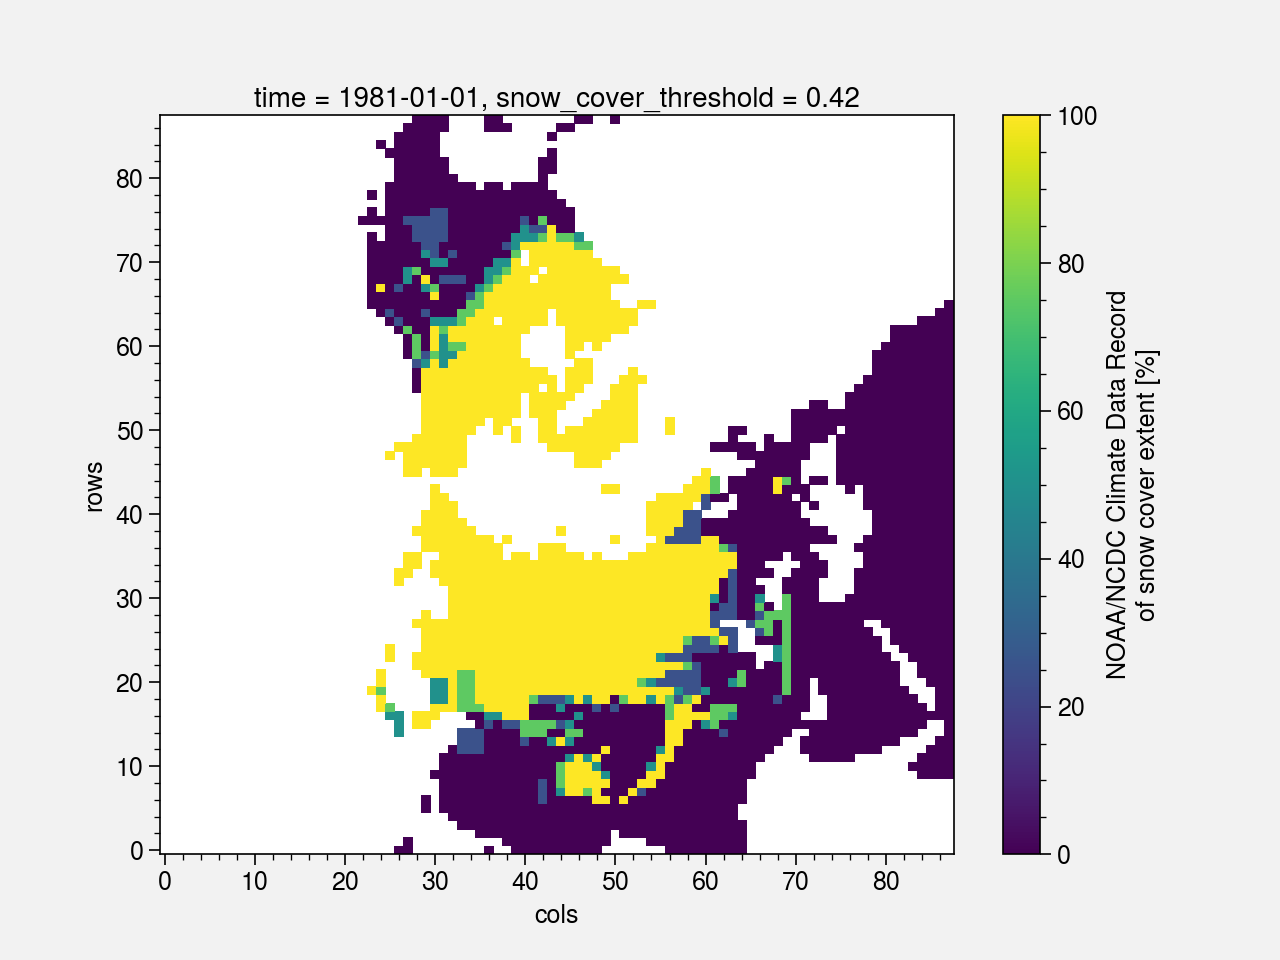

In [7]:
obs[0].plot()

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 
Value of cells in the new grid that are outside the old grid's domain #15 (https://github.com/JiaweiZhuang/xESMF/issues/15)

In [7]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=False, reuse_weights=True)
regridder_obs = add_matrix_NaNs(regridder_obs)
print(regridder_obs)

# Regrid the data
obs_regrid = regridder_obs(obs)

Create weight file: bilinear_88x88_143x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_143x144.nc 
Reuse pre-computed weights? True 
Input grid shape:           (88, 88) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

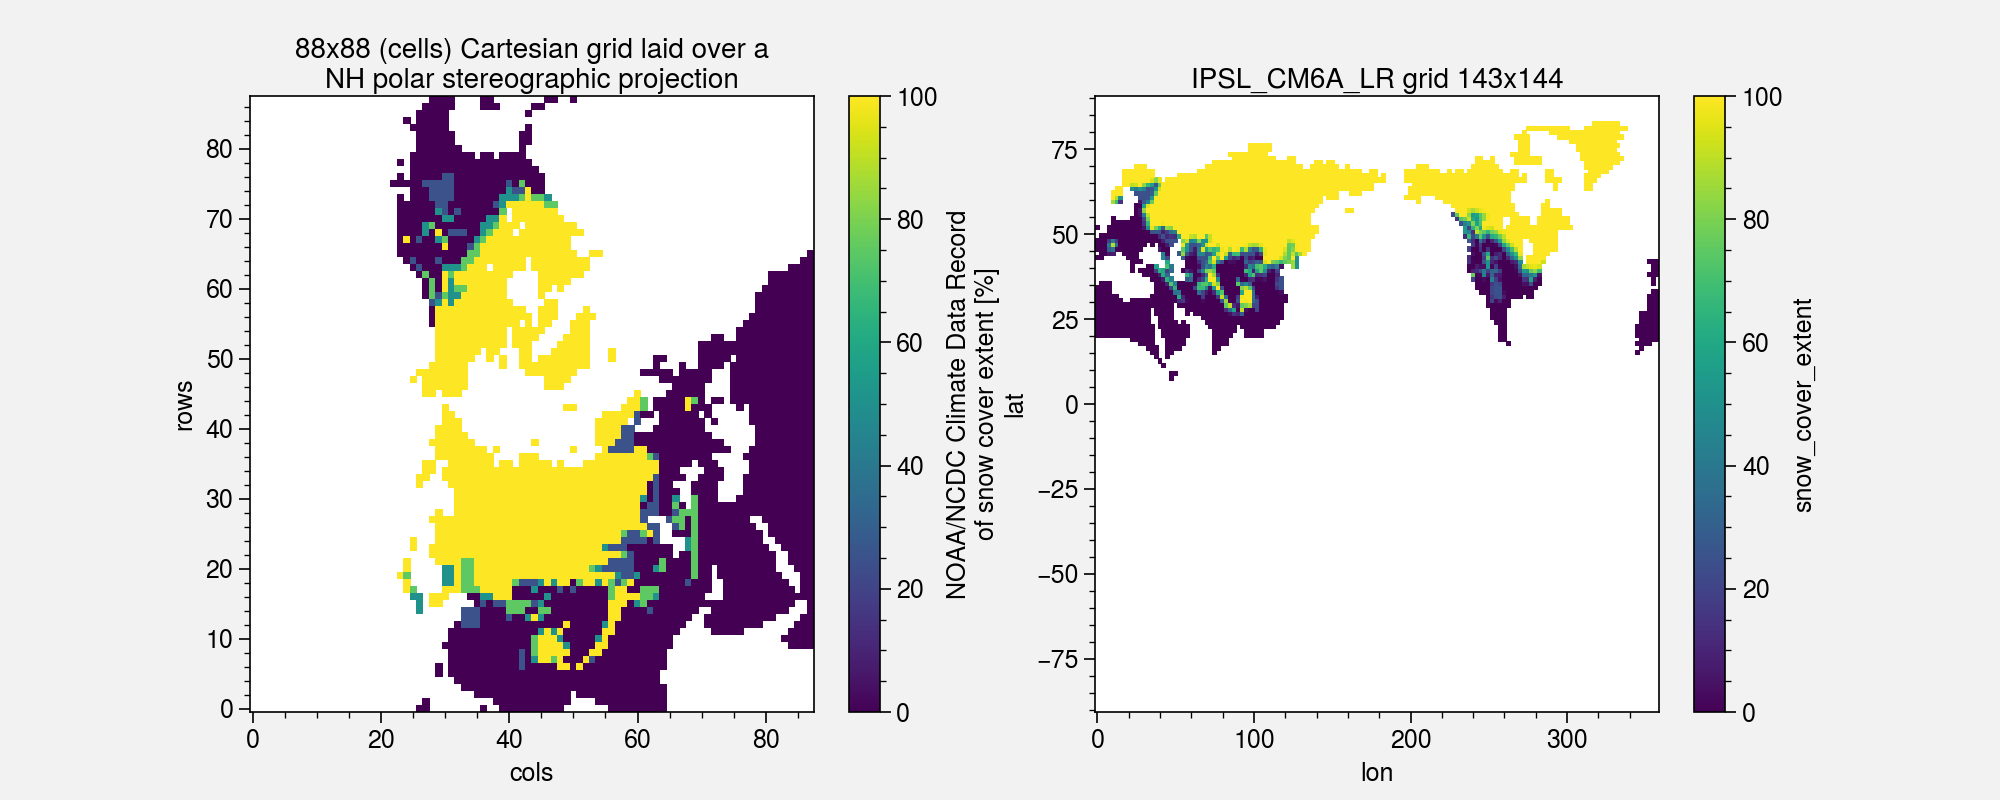

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(121)
obs[0].plot()
plt.title('88x88 (cells) Cartesian grid laid over a\nNH polar stereographic projection')
plt.subplot(122)
obs_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

### Regrid HR

In [8]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(da_HR, da_historical, 'bilinear', periodic=True, reuse_weights=True)
print(regridder_HR)

# Regrid the data
da_HR_regrid = regridder_HR(da_HR)

Reuse existing file: bilinear_361x512_143x144_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


Text(0.5, 1.0, 'da_HR_regrid')

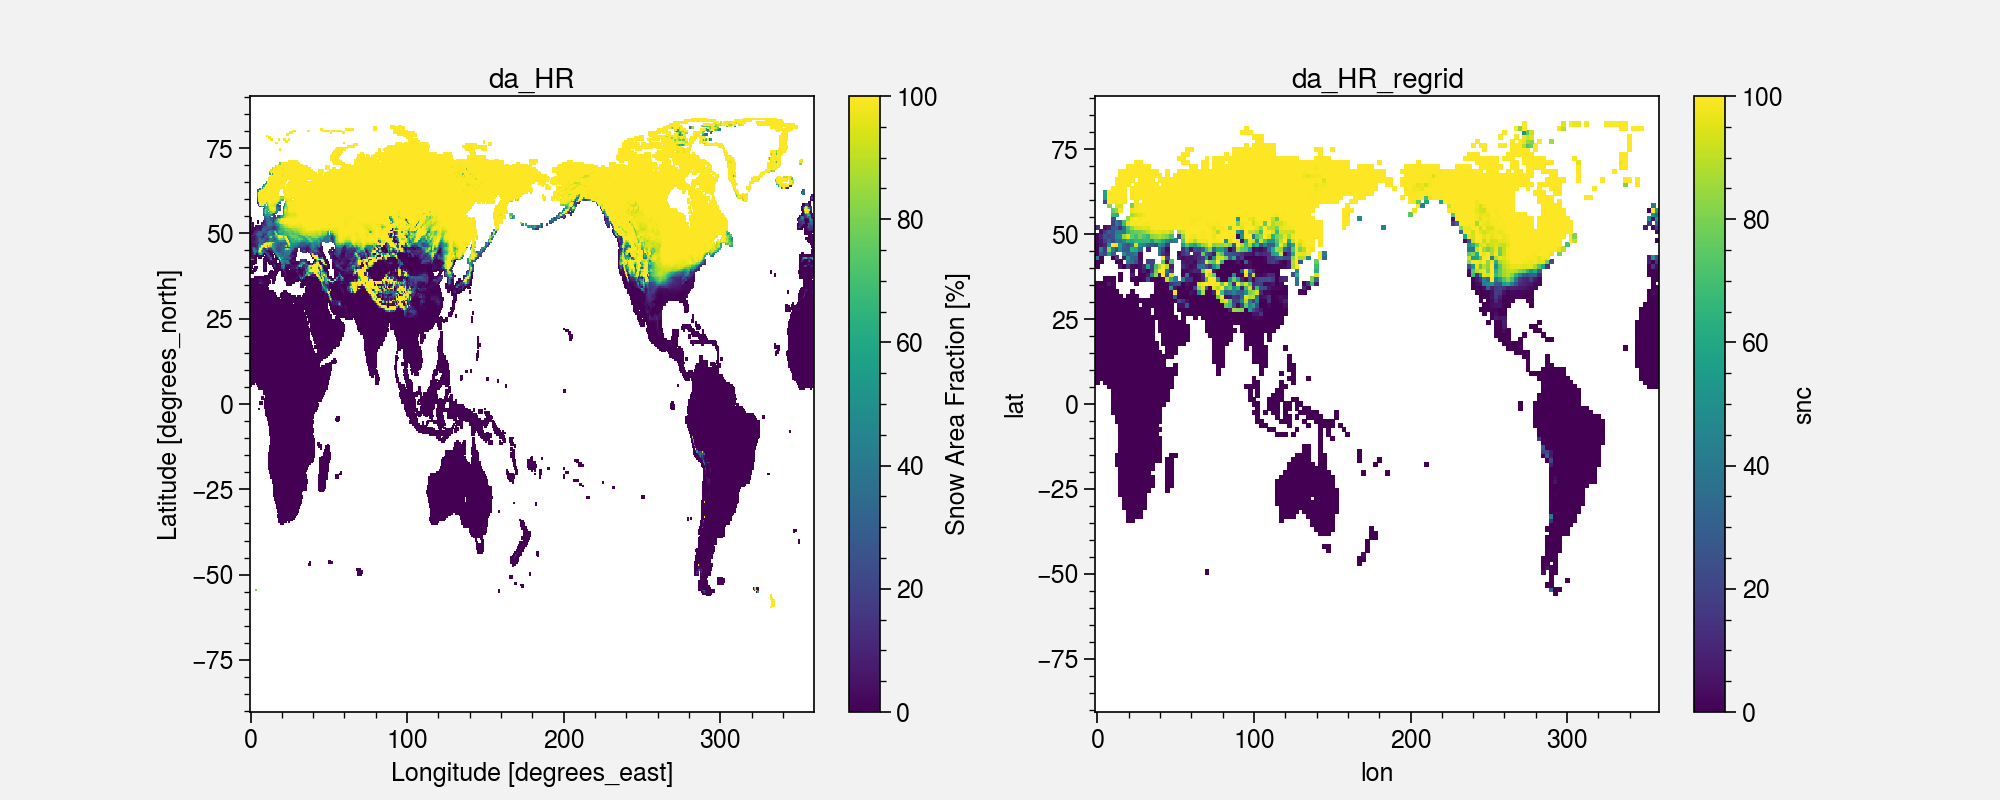

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(121)
da_HR[0].plot()
plt.title('da_HR')
plt.subplot(122)
da_HR_regrid[0].plot()
plt.title('da_HR_regrid')

## Load ERA-Interim
- ERA-Interim (https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era-interim)

The way the SCF is computed: https://confluence.ecmwf.int/display/CKB/ERA-Interim%3A+documentation#ERAInterim:documentation-Computationofnear-surfacehumidityandsnowcover

Finally the snow depth is already in water equivalent: https://apps.ecmwf.int/codes/grib/param-db/?id=33

So to compute the SCF: 

$$ \mathrm{SCF} = \mathrm{min}(1, \mathrm{RW} \times \frac{\mathrm{SD}}{15} ) $$  

where RW is density of water equal to 1000

In [9]:
sd = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/sd.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).sd.sel(time=period).load()
sd

<xarray.DataArray 'sd' (time: 408, lat: 241, lon: 480)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2014-12-01
Attributes:
    long_name:     Snow depth
    units:         m of water equivalent
    num_GRIB:      141
    level_desc:    Surface
    dataset:       Analysis
    actual_range:  [ 0. 10.]

### Compute snow cover

In [10]:
tmp = 1000*sd/15
era = tmp.where(tmp<=1, 1)*100

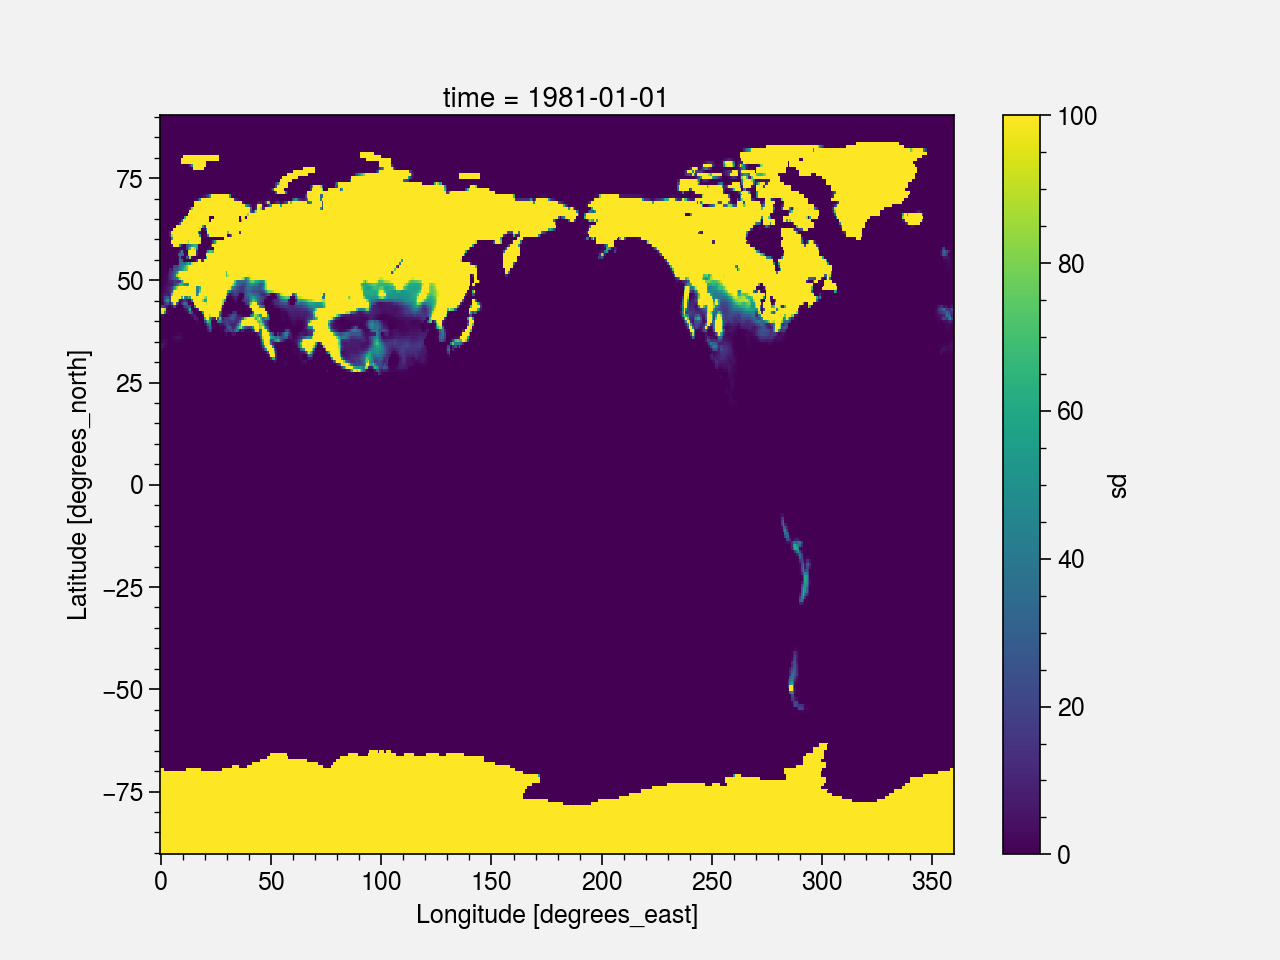

In [15]:
era[0].plot()

### Regrid

In [11]:
regridder_ERAI = xe.Regridder(era, da_historical, 'bilinear', periodic=True, reuse_weights=True)
era_regrid = regridder_ERAI(era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

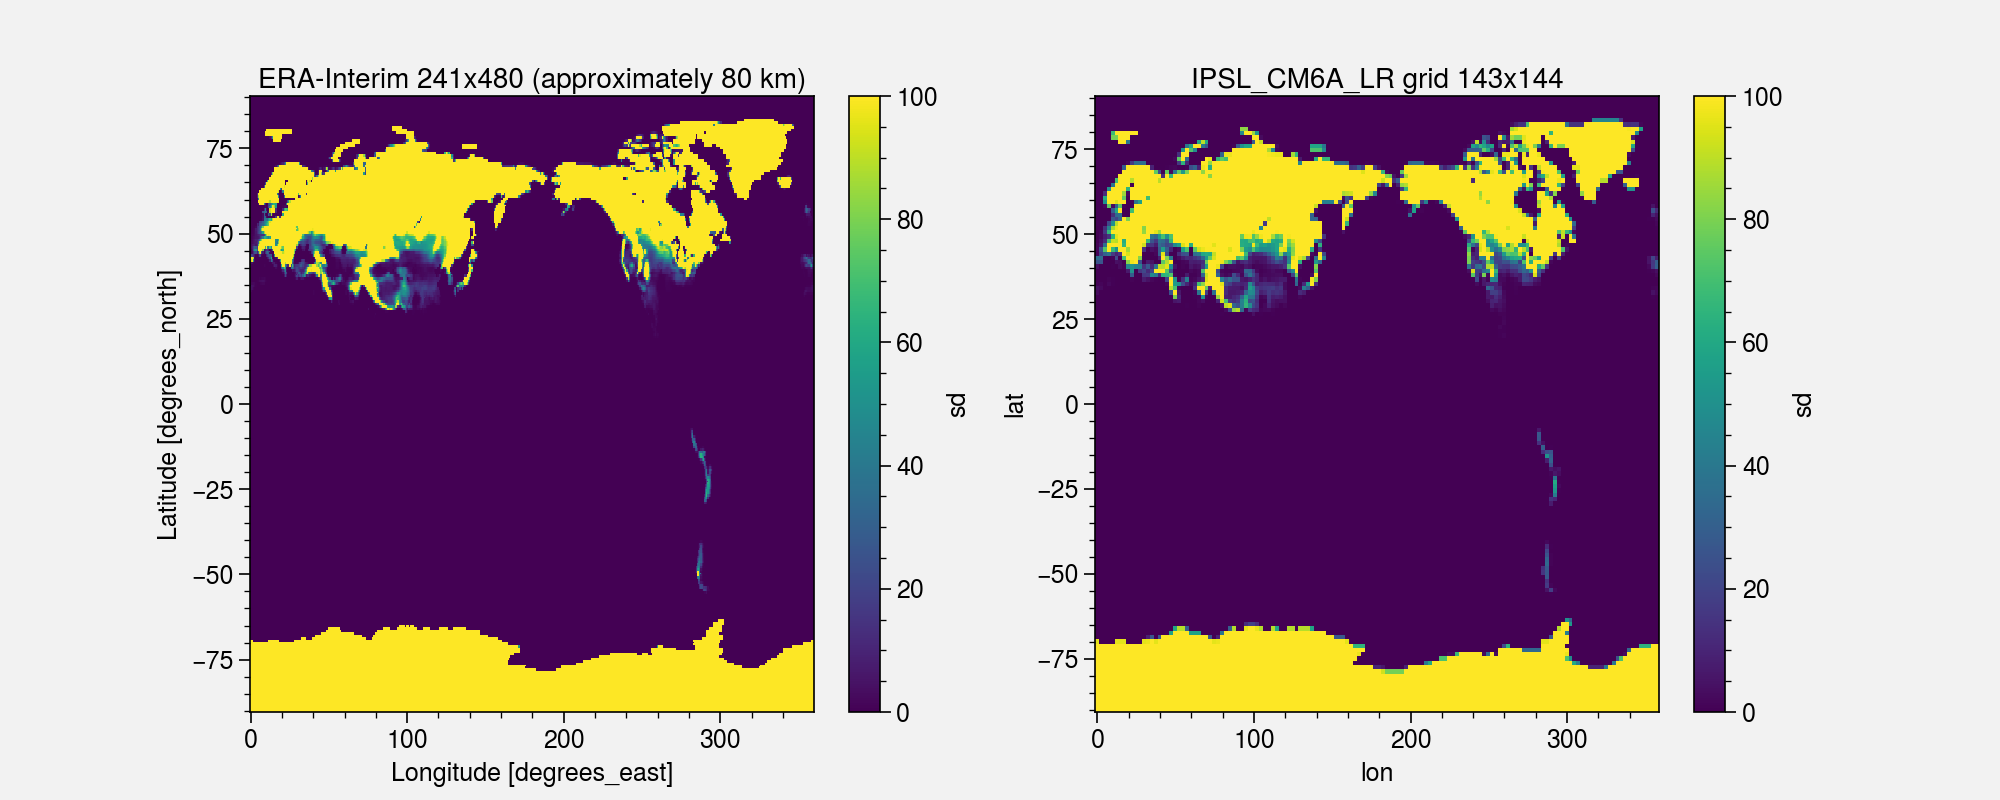

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(121)
era[0].plot()
plt.title('ERA-Interim 241x480 (approximately 80 km)')
plt.subplot(122)
era_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

## Annual Climatology
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?) 

In [23]:
latlim=(0,90)
lonlim=(0,360)

da_historical_clim = u.clim(da_historical.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_historical_clim.load()

da_amip_clim = u.clim(da_amip.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_amip_clim.load()

da_land_hist_clim = u.clim(da_land_hist.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_land_hist_clim.load()

da_HR_regrid_clim = u.clim(da_HR_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_HR_regrid_clim.load()

da_HR_clim = u.clim(da_HR.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_HR_clim.load()

obs_regrid_clim = u.clim(obs_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
obs_regrid_clim.load()

# obs_clim = u.clim(obs.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
# obs_clim.load()

era_regrid_clim = u.clim(era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
era_regrid_clim.load()

era_clim = u.clim(era.sel(lat=slice(latlim[1],latlim[0]), lon=slice(lonlim[0],lonlim[1])))
era_clim.load()

<xarray.DataArray (lat: 121, lon: 480)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
  * lat      (lat) float64 90.0 89.25 88.5 87.75 87.0 ... 3.0 2.25 1.5 0.75 0.0

In [24]:
# We remove HR for keeping the resolution

concat = xr.concat(
    [
        da_historical_clim,
        da_amip_clim,
        da_land_hist_clim,
    ],
    pd.Index(
        [
            'Historical (32)',
            'AMIP (21)',
            'land-hist (1)',
        ], 
        name='exp'
    )
)

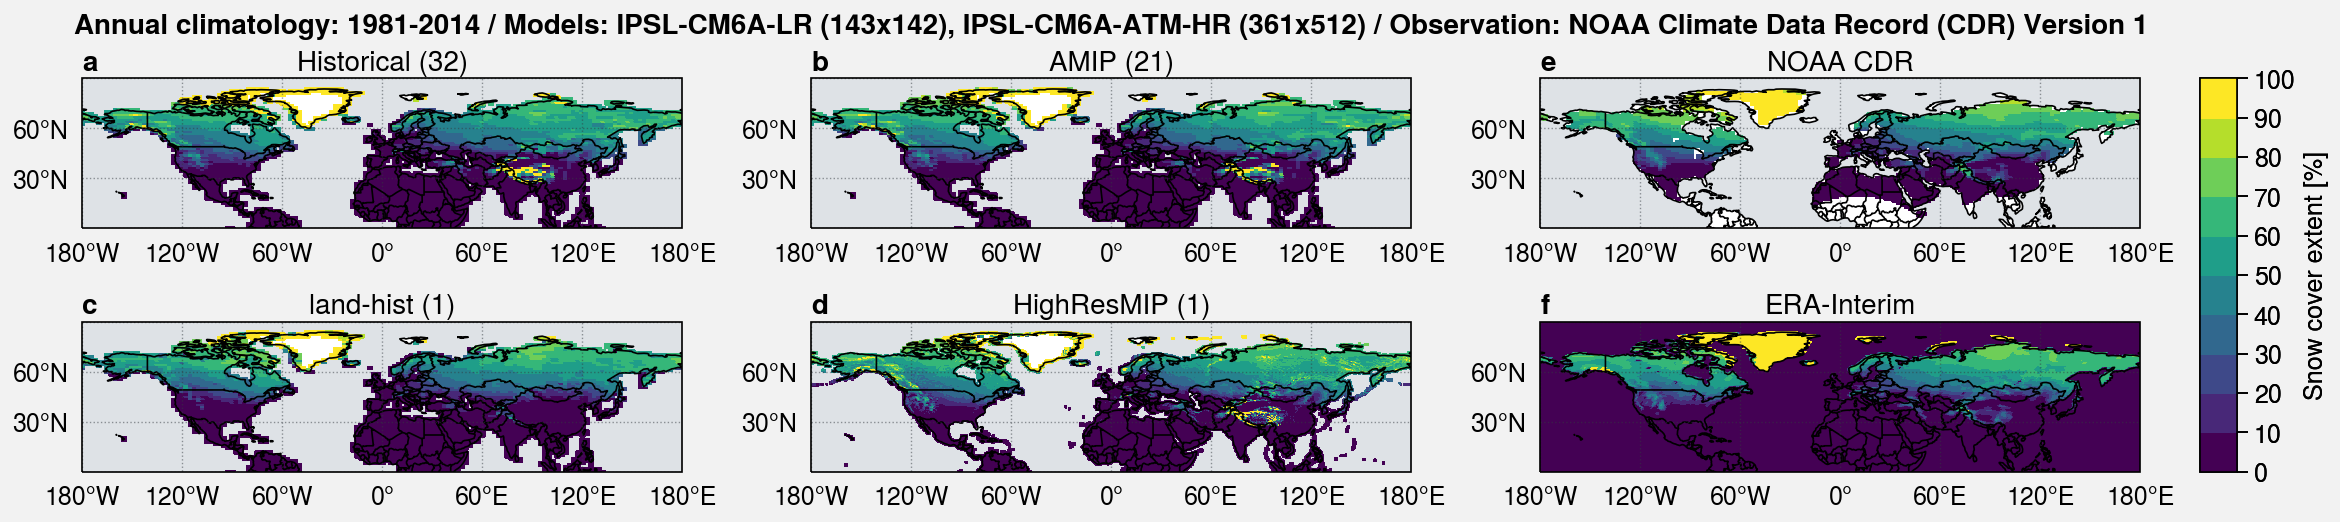

In [25]:
# Final plot

f, axs = plot.subplots([[1, 2, 5], [3, 4, 6]], proj='cyl', share=3, axwidth=3)

extend='neither'

for i, ax in enumerate(axs):
    if i < 3:
        m = ax.pcolormesh(concat.isel(exp=i), cmap=cmap, levels=levels, extend=extend)
        ax.format(title=str(concat.isel(exp=i).exp.values))
    
axs[3].pcolormesh(da_HR_clim, cmap=cmap, levels=levels, extend=extend)
axs[3].format(title='HighResMIP (1)') 

axs[4].pcolormesh(obs_regrid_clim, cmap=cmap, levels=levels, extend=extend)
axs[4].format(title=obs_name) 

axs[5].pcolormesh(era_clim, cmap=cmap, levels=levels, extend=extend)
axs[5].format(title='ERA-Interim')

f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology: 1981-2014 / Models: IPSL-CM6A-LR (143x142), IPSL-CM6A-ATM-HR (361x512) / Observation: "+obs_longname,
    lonlines=60, latlines=30, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/annual_clim_'+var+'_IPSL_CMIP6.png')
# f.save('img/'+var+'/annual_clim_'+var+'_IPSL_CMIP6.pdf')

# Bias
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?) 

In [26]:
bias = xr.concat(
    [
        (da_historical_clim-obs_regrid_clim),
        (da_amip_clim-obs_regrid_clim),
        (da_land_hist_clim-obs_regrid_clim),
        (da_HR_regrid_clim-obs_regrid_clim)
    ],
    pd.Index(
        [
            'Historical (32) - '+obs_name,
            'AMIP (21) - '+obs_name,
            'land-hist (1) - '+obs_name,
            'HighResMIP (1) - '+obs_name
        ], 
        name='bias'
    )
)

In [20]:
bias.min()

<xarray.DataArray ()>
array(-62.33012673)
Coordinates:
    snow_cover_threshold  float32 0.42

In [21]:
bias.max()

<xarray.DataArray ()>
array(90.76925091)
Coordinates:
    snow_cover_threshold  float32 0.42

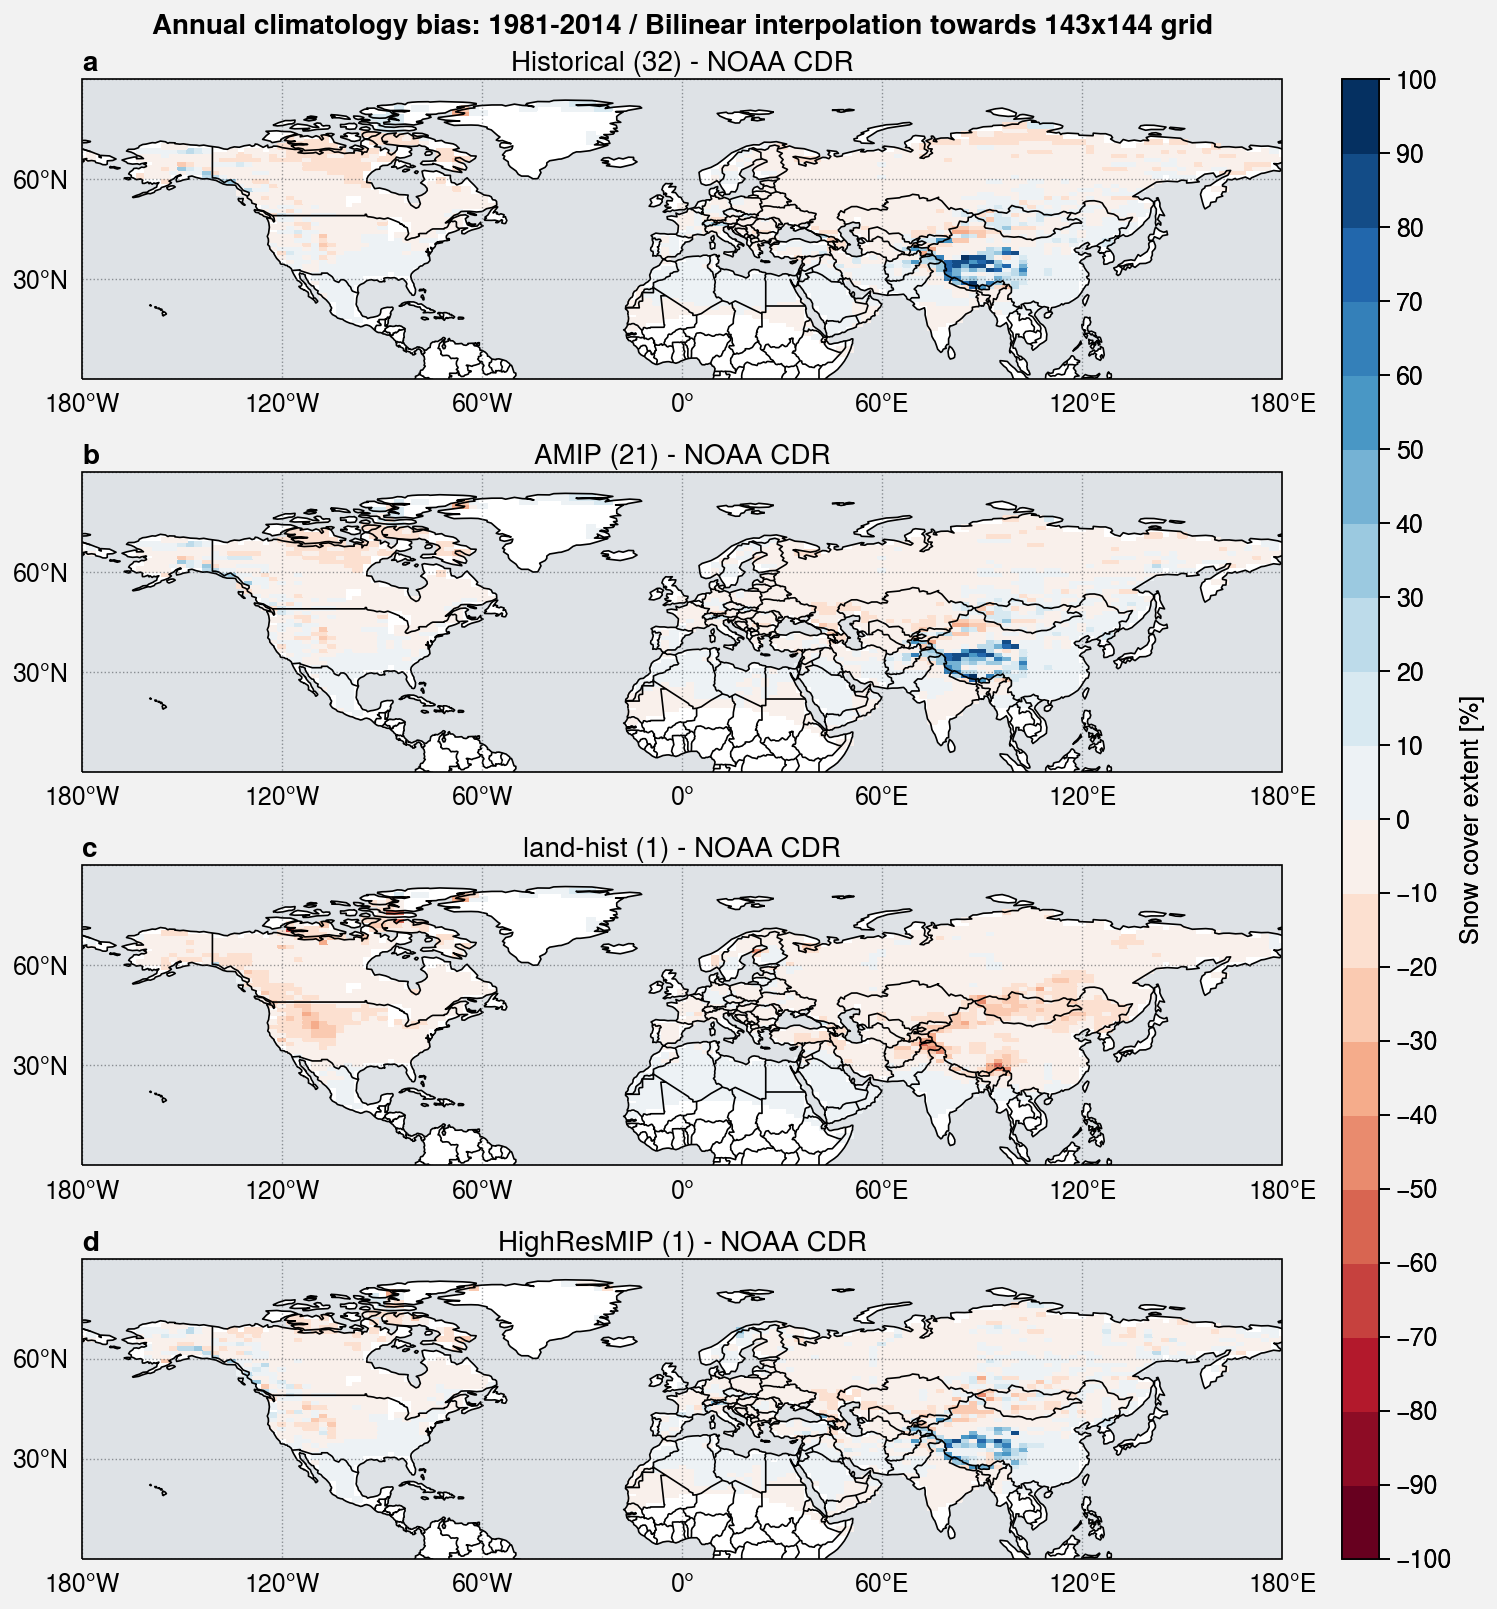

In [32]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=4, axwidth=6)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu', 
        levels=plot.arange(-100,100,10), 
#         extend='both',
#         norm='midpoint'
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=60, latlines=30, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/'+var+'/'+var+'_IPSL_CMIP6_bias_global.jpg')
f.save('img/'+var+'/'+var+'_IPSL_CMIP6_bias_global.png')
f.save('img/'+var+'/'+var+'_IPSL_CMIP6_bias_global.pdf')

# Link with orography?
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Link-with-orography?](#Link-with-orography?)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)   

In [33]:
# Get orog files
orog = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))
orog

mean_topo = xr.open_dataarray('mean_topo.nc').sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))
std_topo = xr.open_dataarray('std_topo.nc').sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))

## Problem of some grid cell that stays at 100%

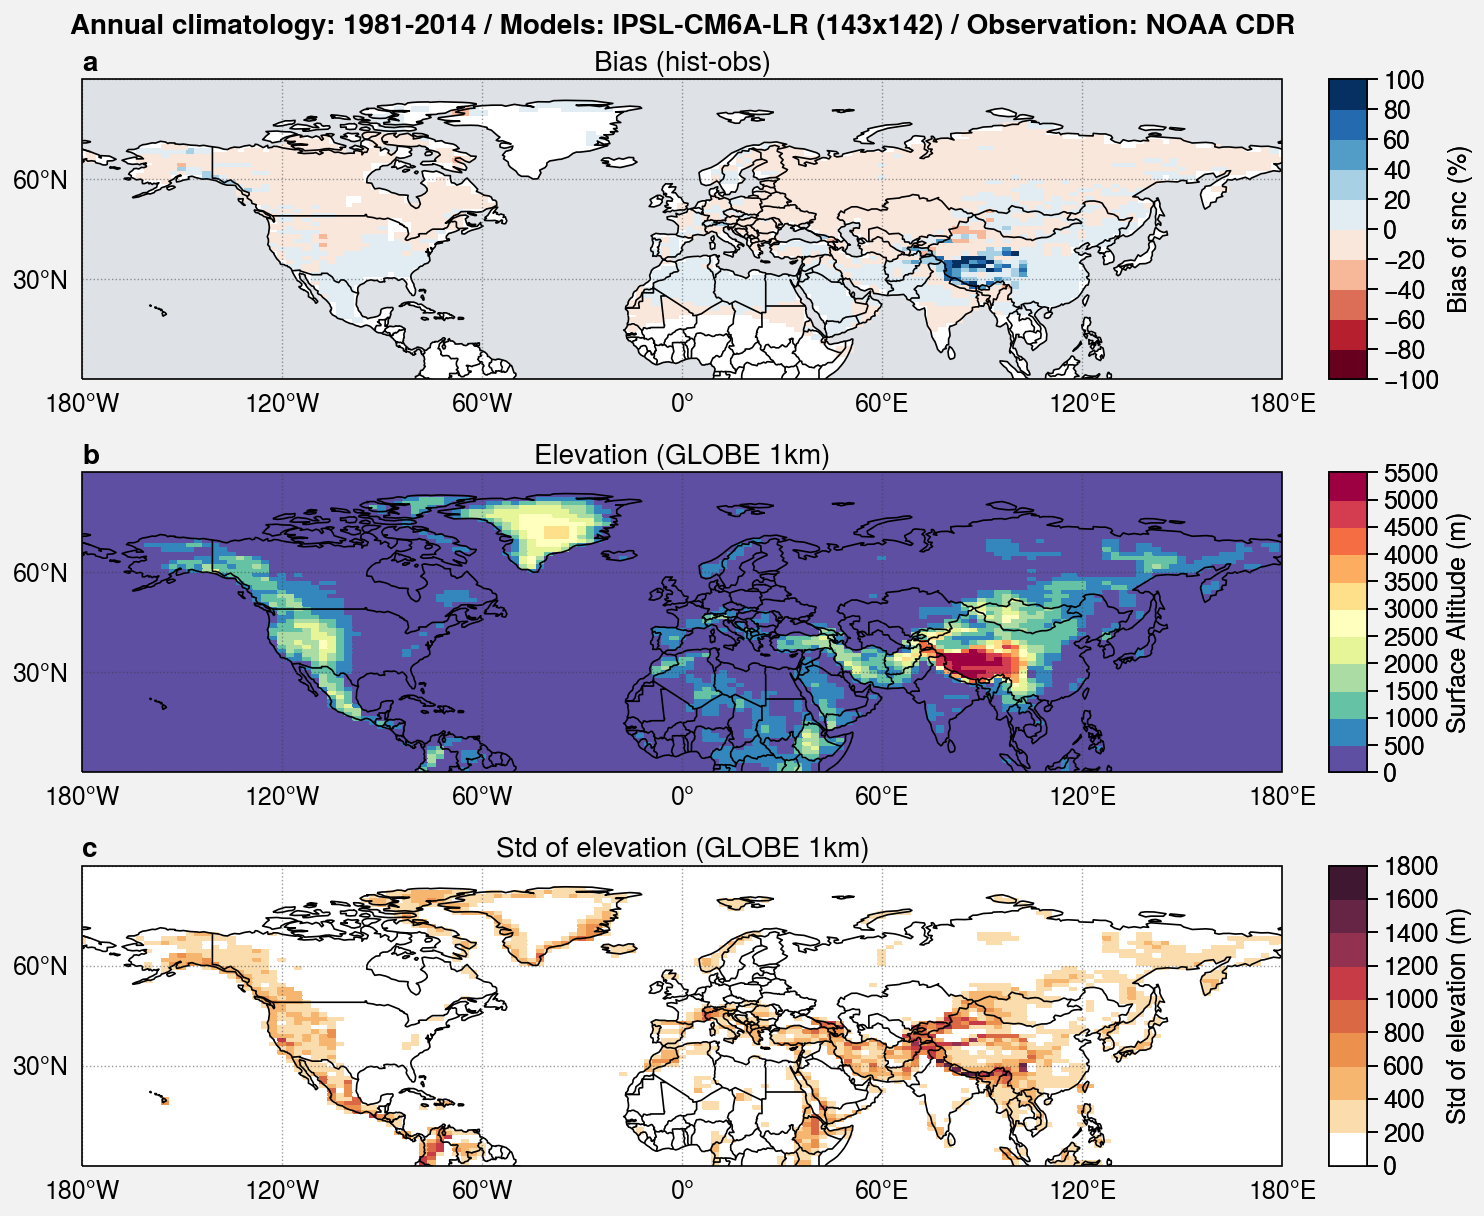

In [42]:
# Final plot

f, axs = plot.subplots(ncols=1, nrows=3, proj='cyl', axwidth=6)

extend='neither'

m0 = axs[0].pcolormesh(bias[0], cmap='RdBu', levels=plot.arange(-100,100,20))
axs[0].format(title='Bias (hist-obs)')
axs[0].colorbar(m0, label='Bias of snc (%)')
  
axs[1].pcolormesh(orog, cmap='Spectral', colorbar='r')
axs[1].format(title='Elevation (GLOBE 1km)')
    
m2 = axs[2].pcolormesh(std_topo)
axs[2].format(title='Std of elevation (GLOBE 1km)')
axs[2].colorbar(m2, label='Std of elevation (m)')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology: 1981-2014 / Models: IPSL-CM6A-LR (143x142) / Observation: "+obs_name,
    lonlines=60, latlines=30, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/'+var+'/orog_'+var+'_global.jpg')
f.save('img/'+var+'/orog_'+var+'_global.png')
f.save('img/'+var+'/orog_'+var+'_global.pdf')